# Étape 2 - Évolutions temporelles

*Durée prévisionnelle : 1h15*

on peut partir du jeu de données parquet déjà constitué ici : https://www.dropbox.com/scl/fi/fzew7xoi555fw3ccxfwhk/all_tweets_hcq_fr.parquet?rlkey=ai3brj2r9xokhzs236r9946iv&dl=0

Dans la suite il est nommé dataset.parquet

**Principales questions que l'on se pose** :

- Comment a évolué l'interaction sur HCQ ?
- Peut-on identifier les principaux moments d'échange ? Comment ?
- Quels sont les utilisateurs qui ont le plus augmenté le nombre de suivi ?

## 1. Charger les données et les mettre en forme

### Préparer le dataset

- Mettre le champ de date en timestamp
- ajouter une colonne qui vaut 1 si c'est un retweet
- ajouer une colonne qui vaut 1 si c'est un tweet original

In [2]:
import pandas as pd

In [3]:
df = pd.read_parquet("dataset.parquet")

In [4]:
df.shape

(3764276, 16)

Passer de chaines de caractères au format date

In [7]:
type(df["created_at"].iloc[0])

str

In [5]:
type(pd.to_datetime(df["created_at"].iloc[0]))

pandas._libs.tslibs.timestamps.Timestamp

In [6]:
df["created_at"] = pd.to_datetime(df["created_at"])
df["is_retweet"] = pd.notnull(df["retweeted_id"])
df["is_tweet"] = pd.isnull(df["retweeted_id"])

Nombre de retweets du corpus

In [7]:
df["is_retweet"].sum()

3117463

Nombre de tweets

In [8]:
df["is_tweet"].sum()

646813

## 2. Évolution générale

### Tracer l'évolution générale de tous les tweets / et des tweets uniques avec un pas de temps par jour / par semaine

> utiliser la méthode resample

- on passe le temps en index sous forme datetime
- on sélectionne une colonne de valeurs numériques
- on agrège par intervalle temporel

In [10]:
df = df.set_index("created_at")

<Axes: xlabel='created_at'>

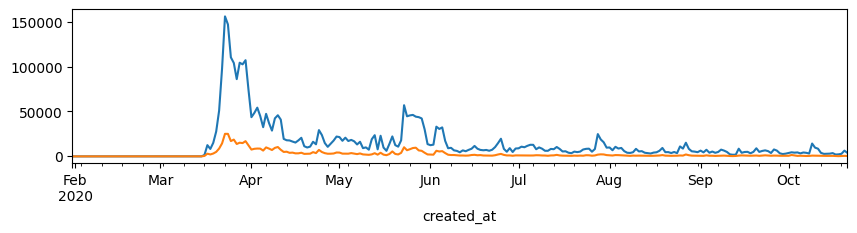

In [11]:
ax = df.resample("d")["is_tweet"].count().plot(figsize=(10,2))
df.resample("d")["is_tweet"].sum().plot(ax=ax)

In [37]:
#df["is_tweet"].resample("d").sum()

On ajoute un titre et une légende avec matplotlib

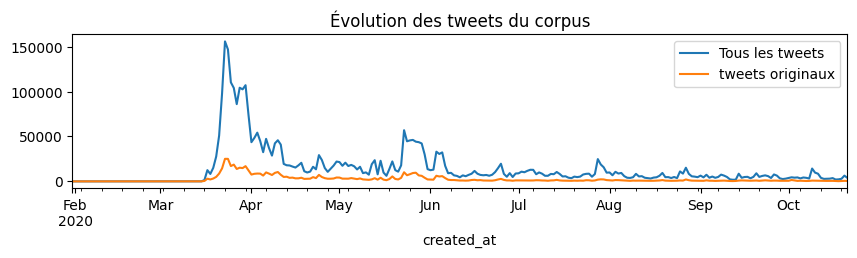

In [12]:
import matplotlib.pyplot as plt

ax = df.resample("d")["is_tweet"].count().plot(figsize=(10,2))
df.resample("d")["is_tweet"].sum().plot(ax=ax)
plt.title("Évolution des tweets du corpus")
plt.legend(["Tous les tweets","tweets originaux"])
plt.show()

### Identifier les principaux pics avec une barre sur le graphique et passer par une recherche pour identifier ce qui s'est passé à ces différents moments pour l'indiquer en label. 

Bonus : comparer avec google trends sur le mot clé pour voir si la dynamique et la même (bonus du bonus : télécharger les données et les mettre sur un même graphique)

Exemple d'une barre ajoutée... et on pourrait rajouter un label en plus

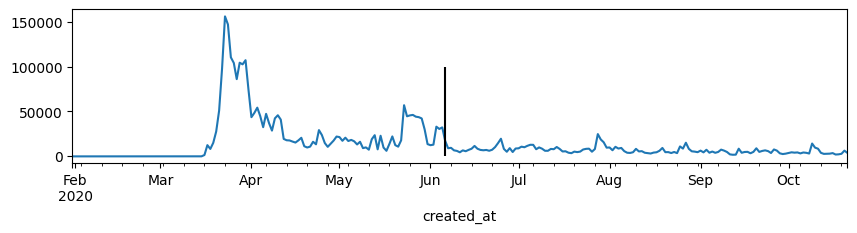

In [13]:
ax = df.resample("d")["is_tweet"].count().plot(figsize=(10,2))
plt.vlines(pd.to_datetime("2020-06-06"),0,100000,color="black")

### Pour les 10 tweets les plus retweetés, tracer un graphique de leur dynamique temporelle par heure

- Prendre les 10 plus retweetés avec head après avoir trié
- Construire à chaque fois une série temporelle sur les retweets
- Afficher

In [64]:
# Sélectionner les 10 tweets les plus retweetés
top_10 = df.set_index("id")["count"].sort_values(ascending=False).head(10)
corpus = []
# Faire une boucle sur leur identifiant
for tweet in list(top_10.index):
    #print(tweet)
    # Sélectionner tous les retweets associés
    serie = df[df["retweeted_id"]==tweet]["id"]
    # Ajouter à un corpus
    corpus.append(serie)

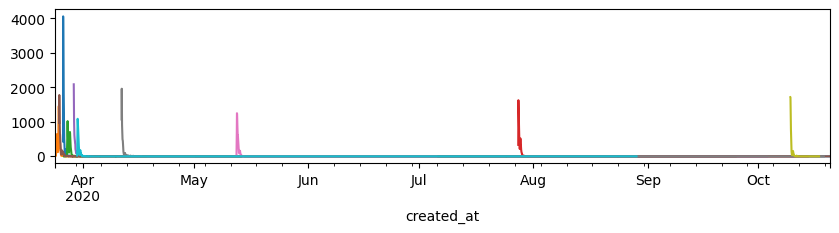

In [65]:
fig,ax = plt.subplots(figsize=(10,2))
for serie in corpus:
    serie.resample("h").count().plot(ax=ax)

Comment faire pour les représenter les uns au dessus des autres ?

## 3. Évolution des thématiques

Pour étudier les thématiques, il est souvent d'usage de se concentrer sur les hashtags, qui jouent un rôle de signalement.

### Construire une expression régulière permettant d'extraire les hashtags du texte et créer une colonne contenant les hashtags, puis faire la liste des 100 hashtags les plus utilisés

In [16]:
import re

In [17]:
def trouver_hashtag(texte):
    """
    Extraire les hashtags et mettre en minuscule
    """
    masque = "(#\w+(?=\s|#|$|\.|\(|\)))" #mots \w avec ensuite un caractère de fin
    texte = texte.lower()
    return re.findall(masque,texte)

Tester la fonction

In [18]:
trouver_hashtag("Ceci est un #text#test et un autre #texte.")

['#text', '#test', '#texte']

On applique la fonction sur le dataset

In [19]:
df["hashtag"] = df["text"].apply(trouver_hashtag)

Quels sont les 10 hashtags les plus fréquents

/home/emilien/anaconda3/envs/jupyter-ai/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  func(*args, **kwargs)
/home/emilien/anaconda3/envs/jupyter-ai/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


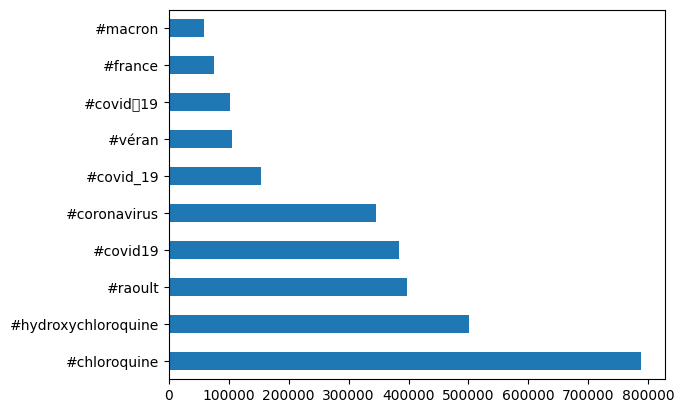

In [21]:
corpus = []
for h in list(df["hashtag"]):
    for m in h:
        corpus.append(m)
        
t = pd.Series(corpus).value_counts()
t[0:10].plot(kind="barh");

### (Pas traité en cours) Comment faire pour regrouper des hashtags similaires ? Le faire pour les 1000 hashtags les plus fréquents

Regarder les différentes stratégies possibles et leur faisabilité

> Regarder la distance de levenshtein https://en.wikipedia.org/wiki/Levenshtein_distance

> Jeter un coup d'oeil sur la bibliothèque skrub et la méthode deduplicate https://skrub-data.org/stable/generated/skrub.deduplicate.html#skrub.deduplicate

> Possible aussi de tenter une méthode mixte nettoyage/dictionnaire

### (Pas traité en cours) Contruire une visualisation des 10 principaux hashtags sur la période, à la fois en valeur absolue (nombre de tweets concernés) et relatifs (proportion aux tweets)

Bonus : identifier les hashtags spécifiques aux pics. Pour un ou tous les pics d'activité, identifier s'il y a des hashtags spécifiques qui ont été utilisés.

Plusieurs méthodes possibles :

- corrélation temporelle
- calcul d'un indicateur de spécificité (indice de Lafon https://www.persee.fr/doc/mots_0243-6450_1980_num_1_1_1008)

Ce travail de nettoyage ne prend dans les faits jamais fin ...

## 4. (pas traité en cours) Engagement des comptes dans les échanges

Tous les comptes ne participent pas de la même manière aux échanges.

### Visualiser l'engagement des comptes

Trouver une manière de visualiser une grande partie des comptes sur un même graphique pour voir la variation d'engagement dans le temps

### Réfléchir aux différentes métriques que nous pourrions utiliser pour capter l'engagement des comptes

### Construire un tableau pour les 1000 comptes les plus actifs avec comme dimensions :

- nombre de tweet
- nombre de retweet
- date du premier tweet par rapport au jour 1 de collecte
- date du dernier tweet sur la période considérée
- date moyenne des tweets
- date médiane des tweets
- + des métriques identifiées à la question précédente

### Bonus - Faire une réduction de dimension (ACP) en 2 axes et projeter les comptes (avec leurs noms)